### In this notebook I performed EDA on the (properly) fetched data

In [1]:
import sqlalchemy as sa 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns 
import numpy as np
import calendar

In [19]:
# Create and connect to engine 
engine = sa.create_engine("sqlite:///../power_outages.db")
connection = engine.connect()

# Create Resolve Time column 
q = sa.text("""SELECT * FROM POWER_OUTAGES""")

# Read to pandas dataframe 
df = pd.read_sql(q, connection)

# Close connection to database 
connection.close()
engine.dispose() 

# Format columns 
df['created_date'] = pd.to_datetime(df['created_date'], utc=False)
df['closed_date'] = pd.to_datetime(df['closed_date'], utc=False)
df['resolution_action_updated_date'] = pd.to_datetime(df['resolution_action_updated_date'], utc=False)
df['resolve_time_hours'] = (df['closed_date'] - df['created_date']).dt.total_seconds() / 3600
df['resolve_time_hours'] = np.floor(pd.to_numeric(df['resolve_time_hours'], errors='coerce')).astype('Int64')
df['incident_zip'] = df['incident_zip'].astype('Int64') 
df["incident_address"] = (df["incident_address"].str.replace(r"\s+", " ", regex=True))

# Filter duplicates and null geospatial values 
df = df[~df.resolution_description.str.contains('duplicate',na=False)] #  > 2000 rows
df = df[~df['latitude'].isnull()] # 2 rows containing duplicates 
df = df[~df['longitude'].isnull()] # 2 rows


In [20]:
df.tail()

,unique_key,created_date,closed_date,descriptor_2,incident_zip,incident_address,street_name,city,status,resolution_description,resolution_action_updated_date,community_board,borough,latitude,longitude,resolve_time_hours
41842,59443046,2023-09-29 08:17:05,NaT,Multiple Rooms or Areas,10305,507 BUEL AVENUE,BUEL AVENUE,STATEN ISLAND,In Progress,None,NaT,02 STATEN ISLAND,STATEN ISLAND,40.581924,-74.086794,<NA>
41843,59457032,2023-09-29 04:01:09,2023-10-06,Entire Building,11201,256 PACIFIC STREET,PACIFIC STREET,BROOKLYN,Closed,None,2023-10-06,02 BROOKLYN,BROOKLYN,40.688287,-73.990387,163
41844,59446660,2023-09-28 22:57:39,2023-10-02,Entire Apartment,11226,369 OCEAN AVENUE,OCEAN AVENUE,BROOKLYN,Closed,None,2023-10-02,14 BROOKLYN,BROOKLYN,40.653724,-73.961686,73
41845,59443143,2023-09-28 22:45:55,2023-09-29,Entire Apartment,11419,117-19 101 AVENUE,101 AVENUE,SOUTH RICHMOND HILL,Closed,None,2023-09-29,09 QUEENS,QUEENS,40.689549,-73.827458,1
41846,59453618,2023-08-10 15:39:40,2023-08-14,Entire Building,11201,2 METROTECH CENTER,METROTECH CENTER,BROOKLYN,Closed,None,2023-08-14,02 BROOKLYN,BROOKLYN,40.693726,-73.985695,80


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 39753 entries, 0 to 41846
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   unique_key                      39753 non-null  int64         
 1   created_date                    39753 non-null  datetime64[ns]
 2   closed_date                     39373 non-null  datetime64[ns]
 3   descriptor_2                    39753 non-null  object        
 4   incident_zip                    39753 non-null  Int64         
 5   incident_address                39753 non-null  object        
 6   street_name                     39753 non-null  object        
 7   city                            39753 non-null  object        
 8   status                          39753 non-null  object        
 9   resolution_description          39553 non-null  object        
 10  resolution_action_updated_date  39732 non-null  datetime64[ns]
 11  communi

In [28]:
def plot_month_distribution(full_df, years=None):
    """
    Creates a grouped bar plot showing monthly distribution across multiple years.
    
    Parameters:
    -----------
    full_df : DataFrame
    years : List of years.If None, uses all years in the data.
    """

    
    try:
        # Filter years if specified
        df = full_df.copy()
        if years is not None:
            df = df[df["created_date"].dt.year.isin(years)]
        
        # Extract year and month
        df["year"] = df["created_date"].dt.year
        df["month"] = df["created_date"].dt.month
        
        # Create the plot - seaborn handles the grouping automatically
        plt.figure(figsize=(12, 6))
        ax = sns.countplot(data=df, x="month", hue="year", palette="bright")
        
        # Set x-axis labels to month abbreviations
        ax.set_xticks(range(12))
        ax.set_xticklabels(calendar.month_abbr[1:], rotation=0)
        
        plt.title("Power Outage Distribution by Month and Year")
        plt.xlabel("Month")
        plt.ylabel("Count")
        plt.legend(title="Year", bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        
    except ValueError as e:
        print("Error in plotting:", e)

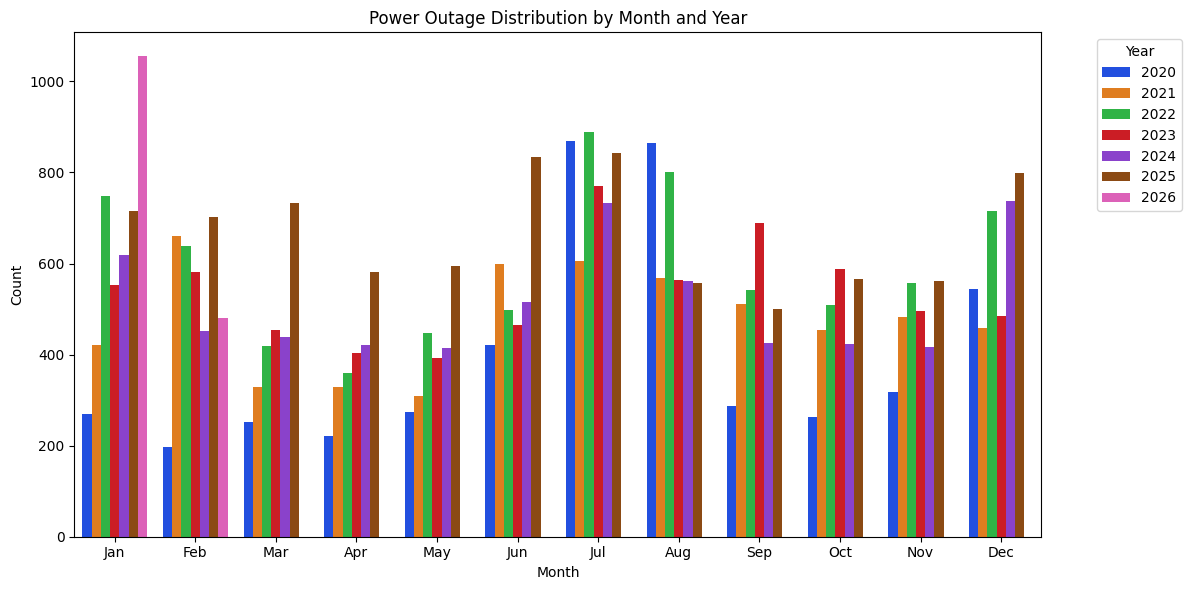

In [29]:
plot_month_distribution(df)

As expected, the summer and winter months have the most power outages for each year. The complaint counts for February 2026 is incomplete (retrieved mid-Feb) but January 2026 had the highest power outage complaints compared to other years.

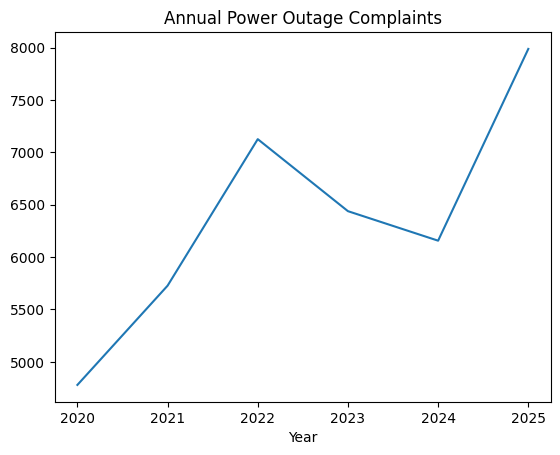

In [39]:
subset_df = df[~df.created_date.dt.year.eq(2026)]
yearly_counts = subset_df['created_date'].dt.year.value_counts().sort_index()
yearly_counts.plot(kind='line')
plt.title("Annual Power Outage Complaints")
plt.xlabel("Year")
plt.show()
